<a href="https://colab.research.google.com/github/timidsurgeon/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## @channel Hey everyone! Today we'll be starting off with a Walkie-Talkie. In Walkie-Talkies you'll be split into small groups where you answer the questions posted in this channel. Half of your career (especially interviews) as a data scientist will be about communicating and explaining your ideas to others. This helps you prepare for that and review material, as well as build community across our cohort. Today's your first one, so the questions will be about getting you used to the format and thinking about what it is you're doing as a data scientist.

#### Question 1: What are numpy and pandas and what are they used for?

Numpy and pandas are both libraries that are integrated well into the Python language. They are used for data analysis and visualization. Pandas offers easy-to-use data structures and data analysis tools. Numpy allows for array manipulation, and integrates the use of linear algebra. 

#### Question 2: What is data science to you?

Data science is the use of data to extract knowledge and insights. It encompasses the use of statistical models and data analysis. Data scientists source, manage, and analyze large amounts of data. 

#### Question 3: What made you transition into data science?

The ability to be able to "forcast" well into the future using statistics and to be able to arrive at meaningful conclusions was something that really interested me about the field. I find it really intriguing to be able to come across patterns that were not apparent before making the analysis and visualizations. 

#### Question 4: What is the most confusing topic from week one of class?

The most confusing topic was the part of the lecture that dealt with merging two datasets together. 

#### Question 5: What would you love to acquire if there were no limitations?

I would love th acquire the ability to pick and memorize all the different functions easily without having to constantly look back at my notes for clarification. I find myself having to constantly look back and forth between my notes and the assignments because of the syntax. 

#### Question 6: What would you do with that data (projects, startups, apps)?

I would look into working on projects with the data and seeing what type of conclusions I can derive from the information. Hopefully, they are meaningful-enough conclusions that I can use to better the life and quality of life of myself and others. 

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
from collections import namedtuple

User = namedtuple('User', ['purchased','time_on_site', 'mobile'])
example_user = User(False, 12, False)
example_user

User(purchased=False, time_on_site=12, mobile=False)

In [0]:
example_user.time_on_site

12

In [0]:
# tuples are immutable
example_user.time_on_site = 30

AttributeError: ignored

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# random float between 10 and 600 seconds
random.uniform(10, 600)

245.77305260966776

In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=241.2886953123564, mobile=True), User(purchased=False, time_on_site=133.21681391889956, mobile=True), User(purchased=False, time_on_site=80.90282863854814, mobile=True), User(purchased=False, time_on_site=10.54171183078693, mobile=True), User(purchased=False, time_on_site=84.97614362768064, mobile=True), User(purchased=True, time_on_site=31.201240844434874, mobile=True), User(purchased=False, time_on_site=415.4293037553443, mobile=False), User(purchased=False, time_on_site=23.667395082288348, mobile=True), User(purchased=False, time_on_site=39.0105815671542, mobile=True), User(purchased=False, time_on_site=113.18186006141289, mobile=True)]


In [0]:
# prints the output of the users going up and down instead of side to side 
users[:10]

[User(purchased=True, time_on_site=241.2886953123564, mobile=True),
 User(purchased=False, time_on_site=133.21681391889956, mobile=True),
 User(purchased=False, time_on_site=80.90282863854814, mobile=True),
 User(purchased=False, time_on_site=10.54171183078693, mobile=True),
 User(purchased=False, time_on_site=84.97614362768064, mobile=True),
 User(purchased=True, time_on_site=31.201240844434874, mobile=True),
 User(purchased=False, time_on_site=415.4293037553443, mobile=False),
 User(purchased=False, time_on_site=23.667395082288348, mobile=True),
 User(purchased=False, time_on_site=39.0105815671542, mobile=True),
 User(purchased=False, time_on_site=113.18186006141289, mobile=True)]

In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,241.288695,True
1,False,133.216814,True
2,False,80.902829,True
3,False,10.541712,True
4,False,84.976144,True


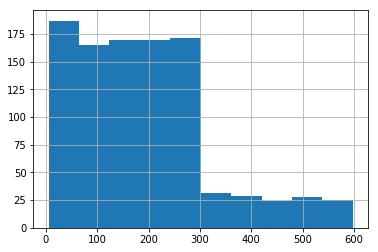

In [0]:
user_data.time_on_site.hist();

In [0]:
import numpy as np 

In [0]:
# takes in mean and standard deviation; normalizes the histogram
np.random.normal(10,2)

9.883313599416839

In [0]:
# times modified to represent how much time they spend; more representative 
users = []

for _ in range(250):
  # Desktop users
  time_on_site = np.random.normal(9.4*60, 3*60)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = np.random.normal(7.5*60, 2.5*60)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=463.18427759957945, mobile=True), User(purchased=False, time_on_site=425.39764306861963, mobile=True), User(purchased=True, time_on_site=457.4487250574005, mobile=True), User(purchased=True, time_on_site=472.20325151096256, mobile=True), User(purchased=False, time_on_site=462.8006166555106, mobile=True), User(purchased=False, time_on_site=271.50747653572677, mobile=False), User(purchased=True, time_on_site=427.5978577605387, mobile=False), User(purchased=True, time_on_site=574.687703178536, mobile=False), User(purchased=False, time_on_site=412.9549009976221, mobile=True), User(purchased=True, time_on_site=976.9483982160118, mobile=False)]


In [0]:
users[:10]

[User(purchased=False, time_on_site=463.18427759957945, mobile=True),
 User(purchased=False, time_on_site=425.39764306861963, mobile=True),
 User(purchased=True, time_on_site=457.4487250574005, mobile=True),
 User(purchased=True, time_on_site=472.20325151096256, mobile=True),
 User(purchased=False, time_on_site=462.8006166555106, mobile=True),
 User(purchased=False, time_on_site=271.50747653572677, mobile=False),
 User(purchased=True, time_on_site=427.5978577605387, mobile=False),
 User(purchased=True, time_on_site=574.687703178536, mobile=False),
 User(purchased=False, time_on_site=412.9549009976221, mobile=True),
 User(purchased=True, time_on_site=976.9483982160118, mobile=False)]

In [0]:
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,463.184278,True
1,False,425.397643,True
2,True,457.448725,True
3,True,472.203252,True
4,False,462.800617,True


In [0]:
user_data['time_on_site_min'] = user_data['time_on_site'] / 60 
user_data.head()

,purchased,time_on_site,mobile,time_on_site_min
0,False,463.184278,True,7.719738
1,False,425.397643,True,7.089961
2,True,457.448725,True,7.624145
3,True,472.203252,True,7.870054
4,False,462.800617,True,7.713344


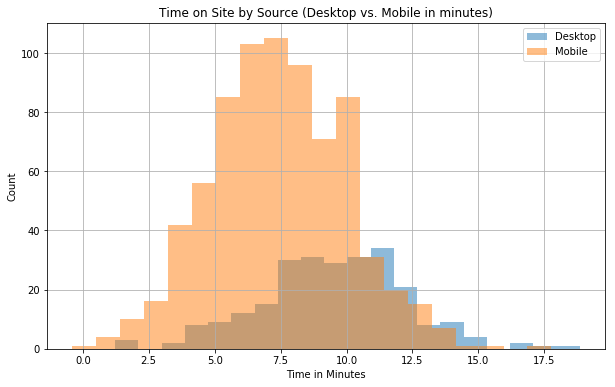

In [0]:
import matplotlib.pyplot as plt

user_data.groupby('mobile').time_on_site_min.hist(bins=20, alpha=0.5, figsize=(10,6))
plt.title('Time on Site by Source (Desktop vs. Mobile in minutes)')
plt.ylabel('Count')
plt.xlabel('Time in Minutes')
plt.legend(['Desktop', 'Mobile'])
plt.show()

In [0]:
# locating the data points that are negative because no time spent can be negative
user_data[user_data.time_on_site < 0.0]

,purchased,time_on_site,mobile,time_on_site_min
974,False,-23.55527,True,-0.392588


In [0]:
# overriding those negative values with zero
user_data.loc[user_data['time_on_site'] < 0.0, 'time_on_site'] = 0.0

In [0]:
# rechecking to confirm that they actually been changed to zero
user_data[user_data.time_on_site < 0.0]

,purchased,time_on_site,mobile,time_on_site_min


In [0]:
user_data['time_on_site_min'] = user_data['time_on_site'] / 60 
user_data.head()

,purchased,time_on_site,mobile,time_on_site_min
0,False,463.184278,True,7.719738
1,False,425.397643,True,7.089961
2,True,457.448725,True,7.624145
3,True,472.203252,True,7.870054
4,False,462.800617,True,7.713344


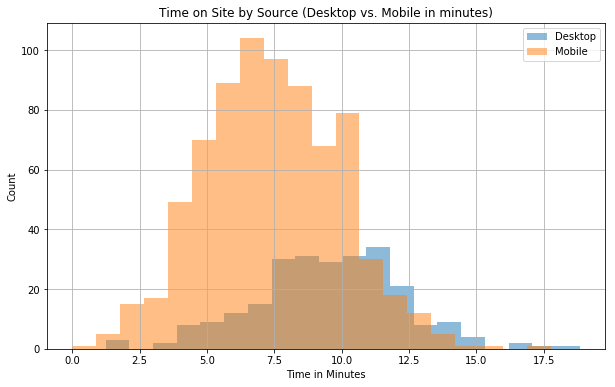

In [0]:
# cut off at zero and there are no more negative values 
user_data.groupby('mobile').time_on_site_min.hist(bins=20, alpha=0.5, figsize=(10,6))
plt.title('Time on Site by Source (Desktop vs. Mobile in minutes)')
plt.ylabel('Count')
plt.xlabel('Time in Minutes')
plt.legend(['Desktop', 'Mobile'])
plt.show()

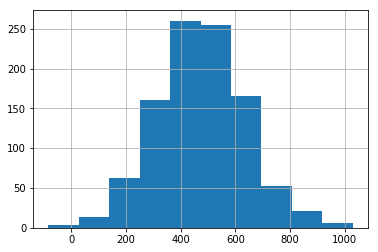

In [0]:
 user_data.time_on_site.hist();

In [0]:
?pd.crosstab()

In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,0.0,61.15572500887794,68.65298111854128,73.8679353322072,74.16657852057915,84.9502637179018,92.22421469318886,105.00147413258048,106.55356329697594,110.19604558218816,112.42983960741219,120.49480987714543,121.6548214381229,122.69385138616866,126.23581852795422,131.10827800525436,138.39825677797512,139.067167112604,144.4187308223154,148.70434022333006,149.3904781933776,151.16663405689343,152.0895069268284,157.87753428402414,161.7980542619764,162.65396195819346,172.9249305241193,175.99745848176303,177.8138190684818,178.35534606458577,178.84277704072605,181.31441818218912,184.85660921115988,187.74139766016282,200.05837946087647,201.02274511108996,201.2508091196836,203.2154897874893,204.33178068576478,204.58806515198222,...,759.1877283281601,765.4436263373055,765.9222051687849,775.7878565385452,777.1312839705001,781.1393183786876,783.509053057723,785.6959037479375,786.2282160297309,787.9744679496446,792.1061783795433,793.9991150653282,798.0893837271219,799.1095019691248,806.5360372748316,806.8104220101269,807.8449678177365,808.8606007557557,811.7247492284041,815.8171029538001,815.9154296544302,819.9085881547421,822.9055739208484,823.399679149622,823.9968207690285,829.6916044499446,839.8417023945153,846.4876656374136,848.0454059972963,857.3038135687202,891.3131134492289,895.5108309281748,905.519495723516,913.368369435672,932.3223368715117,976.9483982160118,1012.8142295890593,1053.6810481017328,1066.2585034630545,1130.5614773934014
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,1,1,...,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
True,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,0,...,0,1,1,0,1,1,0,1,1,0,1,1,1,0,0,1,0,1,1,0,0,1,1,0,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site_min'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'])

purchased,False,True
time_on_site_min,,
"(-0.0188, 3.769]",31,22
"(3.769, 7.537]",211,184
"(7.537, 11.306]",150,282
"(11.306, 15.074]",40,72
"(15.074, 18.843]",2,6


In [0]:
# looking at percentages column-wise
time_bins = pd.cut(user_data['time_on_site_min'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_min,,
"(-0.0188, 3.769]",0.071429,0.038869
"(3.769, 7.537]",0.486175,0.325088
"(7.537, 11.306]",0.345622,0.498233
"(11.306, 15.074]",0.092166,0.127208
"(15.074, 18.843]",0.004608,0.010601


In [0]:
# looking at percentages row-wise 
time_bins = pd.cut(user_data['time_on_site_min'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'], normalize='index')

purchased,False,True
time_on_site_min,,
"(-0.0188, 3.769]",0.584906,0.415094
"(3.769, 7.537]",0.534177,0.465823
"(7.537, 11.306]",0.347222,0.652778
"(11.306, 15.074]",0.357143,0.642857
"(15.074, 18.843]",0.250000,0.750000


In [0]:
# another way to perform the crosstab
pd.crosstab(columns=user_data['purchased'], index=time_bins, normalize='index')

purchased,False,True
time_on_site_min,,
"(-0.0188, 3.769]",0.584906,0.415094
"(3.769, 7.537]",0.534177,0.465823
"(7.537, 11.306]",0.347222,0.652778
"(11.306, 15.074]",0.357143,0.642857
"(15.074, 18.843]",0.250000,0.750000


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_min,,
"(-0.0188, 3.769]",0.071429,0.038869
"(3.769, 7.537]",0.486175,0.325088
"(7.537, 11.306]",0.345622,0.498233
"(11.306, 15.074]",0.092166,0.127208
"(15.074, 18.843]",0.004608,0.010601


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.48,0.418667
True,0.52,0.581333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')

purchased            False               True           
mobile               False     True      False     True 
time_on_site_min                                        
(-0.0188, 3.769]  0.016667  0.092357  0.007692  0.048165
(3.769, 7.537]    0.291667  0.560510  0.123077  0.385321
(7.537, 11.306]   0.441667  0.308917  0.553846  0.481651
(11.306, 15.074]  0.233333  0.038217  0.284615  0.080275
(15.074, 18.843]  0.016667  0.000000  0.030769  0.004587

In [0]:
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_min,,
"(-0.0188, 3.769]",0.071429,0.038869
"(3.769, 7.537]",0.486175,0.325088
"(7.537, 11.306]",0.345622,0.498233
"(11.306, 15.074]",0.092166,0.127208
"(15.074, 18.843]",0.004608,0.010601


## Stanford Open Police Project
https://openpolicing.stanford.edu/


In [0]:
# unzip file and look at the files in the directory
!unzip jb084sr9005_nj_statewide_2019_02_25.csv.zip
!ls

Archive:  jb084sr9005_nj_statewide_2019_02_25.csv.zip
  inflating: share/data/opp-for-archive/nj_statewide_2019_02_25.csv  
jb084sr9005_nj_statewide_2019_02_25.csv.zip  sample_data  share


In [0]:
 %%time
  df = pd.read_csv('./share/data/opp-for-archive/nj_statewide_2019_02_25.csv')
  print(df.shape)

(3845334, 20)
CPU times: user 18.1 s, sys: 1.78 s, total: 19.9 s
Wall time: 19.9 s


In [0]:
df.head()

,raw_row_number,date,time,location,subject_race,subject_sex,officer_id_hash,department_id,type,violation,arrest_made,citation_issued,warning_issued,outcome,frisk_performed,search_conducted,vehicle_color,vehicle_make,vehicle_model,vehicle_registration_state
0,24723,2009-01-10,15:38:41,"31ST / CARMEN, Camden City",black,male,347f40fd4d,A010,vehicular,NaN,True,NaN,NaN,arrest,True,True,SIL,Chrysler,Town & Country,NJ
1,88239,2009-02-06,11:34:36,"@division, Ewing Twp",black,female,e84e551aad,A010,vehicular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101999,2009-02-11,01:34:26,"34TH / WESTFIELD, Camden City",black,male,e008ccd5a2,A010,vehicular,NaN,True,NaN,NaN,arrest,False,True,GRY,Chevrolet,NaN,PA
3,151289,2009-03-03,20:29:16,"MACARTHUR / 12TH, Camden City",black,male,b84c0f827e,A010,vehicular,NaN,True,NaN,NaN,arrest,True,True,BLU,Chevrolet,Tahoe,NJ
4,153223,2009-03-05,22:25:26,"FEDERAL / 10TH, Camden City",black,male,56eb37f85f,A010,vehicular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BLK,Ford,Expedition,NJ


In [0]:
df.isna().sum()

raw_row_number                      0
date                                0
time                                0
location                            0
subject_race                   109431
subject_sex                     18787
officer_id_hash                     0
department_id                       0
type                                0
violation                      916990
arrest_made                   3719812
citation_issued                852818
warning_issued                 858842
outcome                        845936
frisk_performed               3707675
search_conducted              3703294
vehicle_color                  102890
vehicle_make                   143182
vehicle_model                 2887636
vehicle_registration_state      27617
dtype: int64

In [0]:
df.violation.value_counts()

39:4-97 CARELESS DRIVING                                     726267
39:4-98 RATES OF SPEED                                       301189
39:4-88B UNSAFE LANE CHANGE                                  218747
39:3-76.2F REQ WEARING SEATBELTS                             189408
39:4-56 DELAYING TRAFFIC                                     165038
39:3-66 MAINTENANCE ILLUM DEVICE                             139425
39:4-97.3 USE OF HANDS-FREE WIRELESS TELEPHONE               126905
39:4-99 EXCEED SPEED LIMITATIONS                              96289
39:3-75 SAFETY GLASS DEFINED                                  82905
39:3-74 WINDSHIELD WIPERS                                     73668
39:3-33 REG PLATES / FICTITIOUS                               66398
39:4-88A FAILURE TO KEEP RIGHT (PASSENGER CAR)                64332
19:9-1.2 SPEED LIMITS                                         57325
39:3-40 DRIVE WITHOUT LICENSE                                 54652
19:9-1.2A SPEED LIMITS 65 MPH                   

In [0]:
df.violation.value_counts().head()

39:4-97 CARELESS DRIVING            726267
39:4-98 RATES OF SPEED              301189
39:4-88B UNSAFE LANE CHANGE         218747
39:3-76.2F REQ WEARING SEATBELTS    189408
39:4-56 DELAYING TRAFFIC            165038
Name: violation, dtype: int64

In [0]:
df.vehicle_make.value_counts(normalize=True).head(10)

Honda         0.118632
Ford          0.106514
Toyota        0.099623
Chevrolet     0.084403
Nissan        0.081274
Dodge         0.047225
Hyundai       0.037378
Jeep          0.035211
BMW           0.034904
Volkswagen    0.028908
Name: vehicle_make, dtype: float64

In [0]:
df[df.violation == '39:4-98 RATES OF SPEED'].shape

(301189, 20)

In [0]:
df[df.violation == ' 39:4-98 RATES OF SPEED'].shape

(0, 20)

In [0]:
df[df.violation == '39:4-98 RATES OF SPEED'].vehicle_make.value_counts(normalize=True).head(10)

Honda            0.125034
Toyota           0.107939
Ford             0.088320
Nissan           0.084921
Chevrolet        0.074299
BMW              0.043302
Dodge            0.041296
Hyundai          0.039327
Volkswagen       0.032925
Mercedes-Benz    0.031556
Name: vehicle_make, dtype: float64

In [0]:
df.vehicle_color.value_counts()

BLK        855265
SIL        712231
WHI        636554
GRY        374745
BLU        366103
RED        307223
GRN        193176
TAN         83242
GLD         77951
BGE         35110
MAR         33557
BRN         17403
YEL         15338
ONG         11093
PLE         10247
BRO          9166
TEA          1212
DBL           667
LAV           300
CAM           298
LBL           295
AME           267
PNK           221
DGR           186
TRQ           144
CRM           143
BRZ           114
MUL/COL        74
CPR            54
LGR            38
COM            16
TPE             9
MVE             2
Name: vehicle_color, dtype: int64

In [0]:
df[df.violation == '39:4-98 RATES OF SPEED'].vehicle_color.value_counts(normalize=True)

BLK        0.238954
SIL        0.200708
WHI        0.157833
GRY        0.110433
BLU        0.096752
RED        0.077175
GRN        0.043044
TAN        0.020111
GLD        0.019722
BGE        0.009164
MAR        0.009076
BRN        0.004281
YEL        0.003337
ONG        0.002924
BRO        0.002785
PLE        0.002558
TEA        0.000288
DBL        0.000237
AME        0.000081
LBL        0.000081
PNK        0.000078
LAV        0.000074
CAM        0.000071
DGR        0.000064
BRZ        0.000047
TRQ        0.000030
CRM        0.000027
LGR        0.000020
MUL/COL    0.000020
CPR        0.000014
TPE        0.000010
Name: vehicle_color, dtype: float64

In [0]:
df = pd.DataFrame({'a': np.arange(1e6), 
                  'b': np.arange(1e6)})
print(df.shape)
df.head()

(1000000, 2)


,a,b
0,0.0,0.0
1,1.0,1.0
2,2.0,2.0
3,3.0,3.0
4,4.0,4.0


In [0]:
%timeit df['c'] = df['a']**2

100 loops, best of 3: 14.1 ms per loop


In [0]:
%timeit df['c2'] = df['a'].apply(lambda x: x**2)

1 loop, best of 3: 313 ms per loop


In [0]:
df.head()

,a,b,c,c2
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,2.0,2.0,4.0,4.0
3,3.0,3.0,9.0,9.0
4,4.0,4.0,16.0,16.0


In [0]:
import tqdm 

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [0]:
import matplotlib.pyplot as plt 

In [0]:
import pandas as pd

In [0]:
import numpy as np

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/timidsurgeon/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')
print(df.shape)
df.head()

(1200, 4)


,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
Unnamed: 0       1200 non-null int64
age              1200 non-null int64
weight           1200 non-null int64
exercise_time    1200 non-null int64
dtypes: int64(4)
memory usage: 37.6 KB


In [8]:
df.isnull().sum()

Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64

In [9]:
df.count()

Unnamed: 0       1200
age              1200
weight           1200
exercise_time    1200
dtype: int64

In [10]:
df.weight.value_counts()

113    20
108    19
137    19
125    18
128    17
126    17
124    17
156    16
140    16
100    15
116    15
127    15
144    15
136    15
199    15
154    15
110    14
129    14
131    14
117    14
135    13
147    13
150    13
138    13
153    13
160    13
183    13
182    13
139    13
109    13
       ..
236     3
230     3
226     3
222     3
219     3
231     3
217     3
196     3
179     3
167     3
234     2
207     2
225     2
237     2
241     2
215     2
240     1
244     1
242     1
238     1
239     1
228     1
233     1
227     1
224     1
223     1
221     1
220     1
201     1
246     1
Name: weight, Length: 143, dtype: int64

In [11]:
df = df.drop(columns=["Unnamed: 0"])
print(df.head())

   age  weight  exercise_time
0   44     118            192
1   41     161             35
2   46     128            220
3   39     216             57
4   28     116            182


In [12]:
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


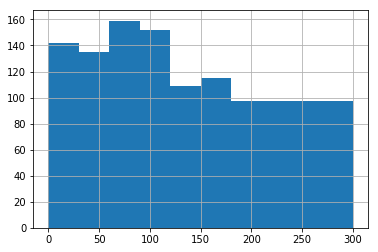

In [13]:
df.exercise_time.hist();

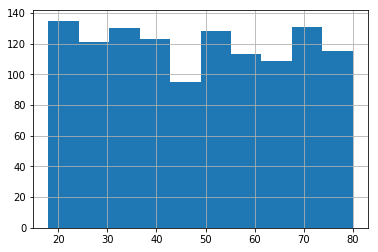

In [14]:
df.age.hist();

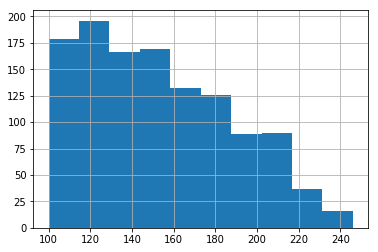

In [15]:
df.weight.hist();

# (Bottom) - no apparent relationship between age and exercise time up until the age of 60. There seems to be sharp decline in exercise time. 

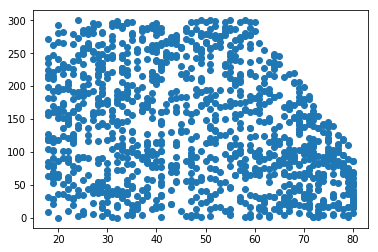

In [16]:
plt.scatter(df.age, df.exercise_time);

# (Bottom) - weight vs. exercise time is inverse linear showing a visible relationship between the two. Less exercise time spent for the heavier-set group. 

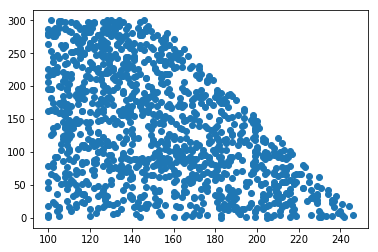

In [0]:
plt.scatter(df.weight, df.exercise_time);

# (Bottom) - age vs. weight is scattered and shows a spurious relationship. There appears to be no apparent trend. 

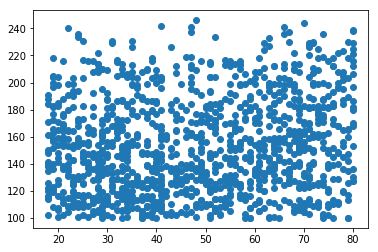

In [0]:
plt.scatter(df.age, df.weight);

In [0]:
df['exercise_time_in_hours'] = df['exercise_time']/60
df.head()

,age,weight,exercise_time,exercise_time_in_hours
0,44,118,192,3.200000
1,41,161,35,0.583333
2,46,128,220,3.666667
3,39,216,57,0.950000
4,28,116,182,3.033333


In [0]:
df['over_25'] = df['age'] > 25
df.head(20)

,age,weight,exercise_time,exercise_time_in_hours,over_25
0,44,118,192,3.200000,True
1,41,161,35,0.583333,True
2,46,128,220,3.666667,True
3,39,216,57,0.950000,True
4,28,116,182,3.033333,True
5,58,103,165,2.750000,True
6,55,161,107,1.783333,True
7,21,188,37,0.616667,False
8,55,216,79,1.316667,True
9,50,127,267,4.450000,True


In [0]:
df.over_25.value_counts()

True     1046
False     154
Name: over_25, dtype: int64

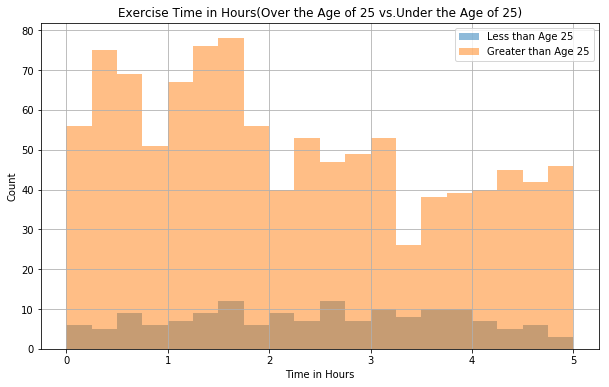

In [0]:
df.groupby('over_25').exercise_time_in_hours.hist(bins=20, alpha=0.5, figsize=(10,6))
plt.title('Exercise Time in Hours(Over the Age of 25 vs.Under the Age of 25)')
plt.ylabel('Count')
plt.xlabel('Time in Hours')
plt.legend(['Less than Age 25', 'Greater than Age 25'])
plt.show()

In [0]:
pd.crosstab(df['over_25'], df['exercise_time'])

exercise_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,296,297,298,299,300
over_25,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,3,1,2,0,0,0,2,1,1,0,0,0,...,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
True,1,4,7,5,5,7,5,1,3,2,5,0,2,6,3,5,5,11,6,5,4,11,7,2,5,3,2,6,3,6,6,3,6,6,5,6,4,5,1,4,...,3,4,3,4,3,4,3,3,1,1,6,0,1,2,3,1,5,6,3,2,5,1,3,1,3,1,1,5,3,7,1,3,2,2,1,4,4,6,2,4


In [0]:
time_bins = pd.cut(df['exercise_time_in_hours'], 5)
pd.crosstab(time_bins, df['over_25'])

over_25,False,True
exercise_time_in_hours,,
"(-0.005, 1.0]",26,252
"(1.0, 2.0]",34,282
"(2.0, 3.0]",36,187
"(3.0, 4.0]",38,154
"(4.0, 5.0]",20,171


In [0]:
time_bins = pd.cut(df['exercise_time_in_hours'], 5)
pd.crosstab(time_bins, df['over_25'], normalize='index')

over_25,False,True
exercise_time_in_hours,,
"(-0.005, 1.0]",0.093525,0.906475
"(1.0, 2.0]",0.107595,0.892405
"(2.0, 3.0]",0.161435,0.838565
"(3.0, 4.0]",0.197917,0.802083
"(4.0, 5.0]",0.104712,0.895288


In [0]:
pd.crosstab(time_bins, df['over_25'], normalize='columns')

over_25,False,True
exercise_time_in_hours,,
"(-0.005, 1.0]",0.168831,0.240918
"(1.0, 2.0]",0.220779,0.269598
"(2.0, 3.0]",0.233766,0.178776
"(3.0, 4.0]",0.246753,0.147228
"(4.0, 5.0]",0.129870,0.163480


In [0]:
average_weight = 196.9 + 167.6/2
print(average_weight)

280.7


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
All of the variables are int-type.
I added in an extra bool column to check if the age of the people was over 25.
2.  What are the relationships between the variables?
It looks like people under the age of 25 were vastly overrepresented in the sample in comparison to older folks. Those numbers were driving the exercise time way up. 
3.  Which relationships are "real", and which spurious?
Gender has not been taken into account, which may play a huge role . Also, their daily schedules are very important in terms of extra time devoted to exercising. 


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)

## Link to lecture
https://youtu.be/rcnSkpbRQh0